In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import copy
from datetime import datetime
import json
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats.mstats import mquantiles

In [12]:
Dewa = pd.read_csv(r'C:\Users\Saeed\OneDrive\Documents\SDP\SDP dataset\CSV\PV HIT and CDTE_DEWA Research Center_Mar 2018-Feb 2019.csv')
Solcast = pd.read_csv(r'C:\Users\Saeed\OneDrive\Documents\SDP\SDP dataset\solcast\Solcast-Data_15m_Dewa-period.csv')

In [13]:
import datetime
#change format of dates for each file

In [14]:
#change date and time format of all files


Dewa['Date_Hour'] = Dewa['Date_Hour'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M'))
Dewa = Dewa.rename(columns={'Date_Hour': 'timestamp'})

#2018-03-01T00:00:00Z
Solcast['PeriodStart'] = Solcast['PeriodStart'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
Solcast = Solcast.rename(columns={'PeriodStart': 'timestamp'})


In [15]:
print('Dewa data shape = ', Dewa.shape)
print('Solcast data shape = ', Solcast.shape)


Dewa data shape =  (35040, 13)
Solcast data shape =  (35040, 21)


In [16]:
dewa_solcast = pd.merge(Dewa, Solcast, on='timestamp', how='right')
print('dewa + solcast shape = ', dewa_solcast.shape)

dewa + solcast shape =  (35040, 33)


In [18]:
dewa_solcast.columns

Index(['timestamp', 'Date', 'Hour', 'METEO_MT_90_rIrradiation',
       'METEO_MT_25_rIrradiation', 'Panasonic_90_rPmpp', 'kWh',
       'Panasonic_25_rPmpp', 'kWh.1', 'FirstSolar_90_rPmpp', 'kWh.2',
       'FirstSolar_25_rPmpp', 'kWh.3', 'PeriodEnd', 'Period', 'AirTemp',
       'Azimuth', 'CloudOpacity', 'DewpointTemp', 'Dhi', 'Dni', 'Ebh', 'Ghi',
       'GtiFixedTilt', 'GtiTracking', 'PrecipitableWater', 'RelativeHumidity',
       'SnowWater', 'SurfacePressure', 'WindDirection10m', 'WindSpeed10m',
       'Zenith', 'AlbedoDaily'],
      dtype='object')

model accuracy is 96.68%



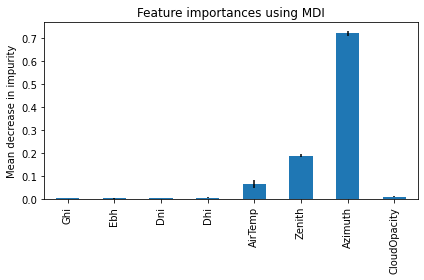

In [35]:
#"ghi":275,"ghi90":284,"ghi10":249,"ebh":154,"dni":430,"dni10":289,"dni90":478,"dhi":120,"air_temp":36,"zenith":69,"azimuth":109,"cloud_opacity":3,"period_end":"2021-10-13T12:30:00.0000000Z","period":"PT30M"

fetures = ['Ghi', 'Ebh', 'Dni', 'Dhi', 'AirTemp', 'Zenith', 'Azimuth','CloudOpacity']
dependant_var = 'kWh'
#choose X ( fetures ) and Y ( dependant var )
X = dewa_solcast[fetures]
y = dewa_solcast[dependant_var]

#train_test_split gives 4 parameters
#X_train and X_test to modify, y_train and y_test stay the same to compare with X later
#this will randomly split data to 80% training and 20% testing. can add parameter random_state=10 to have same samples
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#Input contains NaN, infinity or a value too large for dtype('float64').
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

X_train_np[np.isnan(X_train_np)] = np.median(X_train_np[~np.isnan(X_train_np)])
y_train_np[np.isnan(y_train_np)] = np.median(y_train_np[~np.isnan(y_train_np)])
X_test_np[np.isnan(X_test_np)] = np.median(X_test_np[~np.isnan(X_test_np)])
y_test_np[np.isnan(y_test_np)] = np.median(y_test_np[~np.isnan(y_test_np)])

#classifier for plant 1 linear regression model
clf = RandomForestRegressor()
clf.fit(X_train_np, y_train_np)

model_accuracy = clf.score(X_test_np, y_test_np)
print('model accuracy is {0:.2f}%'.format(model_accuracy*100))

from sklearn.inspection import permutation_importance

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

Random_forest_importances = pd.Series(importances, index=fetures)

fig, ax = plt.subplots()
Random_forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
print('')

In [37]:
fc = json.load(open("forecast(6-10_to_13-10).txt"))
df_fc = pd.DataFrame.from_dict(fc['forecasts'])
df_fc['period_end'] = df_fc['period_end'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f0Z'))
df_fc['period_end'] = df_fc['period_end'].apply(lambda x: x - pd.DateOffset(minutes=30))
df_fc = df_fc.rename(columns={'period_end': 'timestamp'})


In [41]:
df_fc

,ghi,ghi90,ghi10,ebh,dni,dni10,dni90,dhi,air_temp,zenith,azimuth,cloud_opacity,period_end,period
0,108,108,106,39,201,198,201,68,33,80,100,11,2021-10-06 13:00:00,PT30M
1,32,32,30,8,41,41,41,24,32,87,97,12,2021-10-06 13:30:00,PT30M
2,4,4,4,1,5,5,5,3,31,94,93,12,2021-10-06 14:00:00,PT30M
3,0,0,0,0,0,0,0,0,30,101,90,14,2021-10-06 14:30:00,PT30M
4,0,0,0,0,0,0,0,0,30,107,87,1,2021-10-06 15:00:00,PT30M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,568,586,510,384,597,392,663,183,38,50,124,3,2021-10-13 10:30:00,PT30M
332,478,493,429,311,556,363,617,166,38,56,118,3,2021-10-13 11:00:00,PT30M
333,380,392,340,229,488,315,543,150,37,62,114,3,2021-10-13 11:30:00,PT30M
334,275,284,249,154,430,289,478,120,36,69,109,3,2021-10-13 12:00:00,PT30M


In [44]:
test_array = np.array(df_fc[['ghi', 'ebh', 'dni', 'dhi', 'air_temp', 'zenith', 'azimuth','cloud_opacity']])

In [47]:
df_fc['predicted_kWh'] = clf.predict(test_array)

In [49]:
df_fc[['period_end','predicted_kWh']]

,period_end,predicted_kWh
0,2021-10-06 13:00:00,0.034166
1,2021-10-06 13:30:00,0.031839
2,2021-10-06 14:00:00,0.034986
3,2021-10-06 14:30:00,0.032043
4,2021-10-06 15:00:00,0.028640
...,...,...
331,2021-10-13 10:30:00,0.041716
332,2021-10-13 11:00:00,0.043696
333,2021-10-13 11:30:00,0.044587
334,2021-10-13 12:00:00,0.046845
